In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import arch as arch
from arch import arch_model

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [4]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [5]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'CAD/JPY Exchange Rates'}, xlabel='Date'>

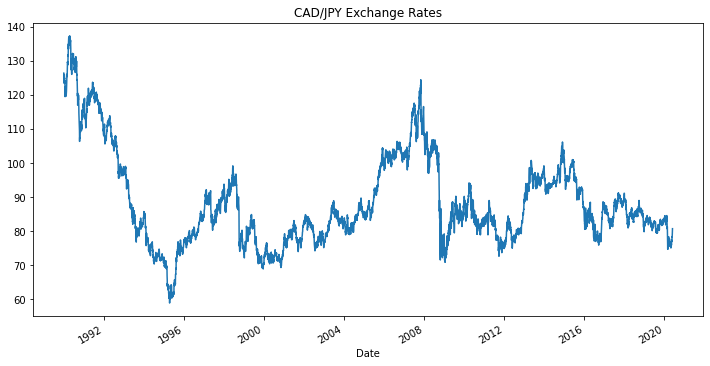

In [6]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(title='CAD/JPY Exchange Rates', figsize=(12,6))

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** 
- **Short Term Patterns** There is a definite short term pattern showing a decline of the value of the CAD vs the JPY for the period 1991 to mid 1995. It can be seen from the plot that 1 Canadian dollar was buying around 138 Japanese yen. Over the next five and a half years this fell dramatically to the point that 1 Canadian dollar was buying around 60 Japanese Yen. Another short term pattern identified is a short term peak in the strength of the CAD vs the JPY around the start of 2018. Otherwise it can be noticed that in the short term there is a lot of volatility which is pretty typical for common currency pairs. 

- **Long Term Patterns** Observing the overall pattern for the CAD/JPY over the long term it can be seen that there is a general downward trend from 1990 to 2020. Excluding the significant downward trend from 1990 to 1996 and the peak in 2008 the trend is generally pretty flat over the long term. For example the value of the CAD vs the JPY in 2004 is very similar to the value in 2020.

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [7]:
# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
cad_jpy_noise, cad_jpy_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [8]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
df_price_noise_trend=cad_jpy_df[["Price"]].copy()

# Add in columns for trend and noise
df_price_noise_trend["noise"] = cad_jpy_noise
df_price_noise_trend["trend"] = cad_jpy_trend
df_price_noise_trend.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:title={'center':'Price vs Trend'}, xlabel='Date'>

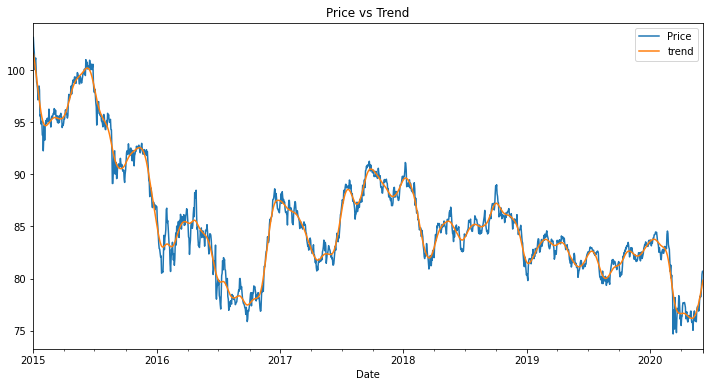

In [9]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
df_price_noise_trend.loc["2015":,["Price","trend"]].plot(title = 'Price vs Trend', figsize=(12,6))

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** 
**Answer:** 
- **Short Term Patterns** Using the trend we can remove a lot of the short term volatility which helps us look at the overall trends. It can be seen that there is generally an upward trend that follows a downward trend. The duration of these trends are generally over a six month duration. Excluding 2020 it is observed that there is a shorter term trend in that the value of the CAD is stronger against the JPY at the start of each year compared to the end.  

- **Long Term Patterns** Observing the overall pattern for the CAD/JPY over the long term for this five year period it can be summarised as an overal downtrend. This is most prevalend early in the sample, with the last 4 years of the sample showing short term volatility but fairly flat. 

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

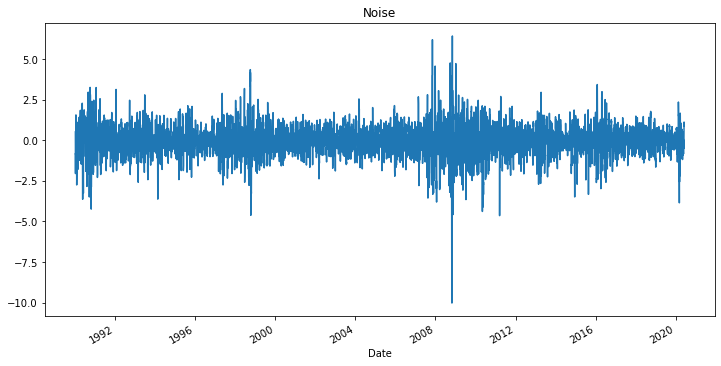

In [10]:
# Plot the Settle Noise
df_price_noise_trend.loc[:,"noise"].plot(title = 'Noise', figsize=(12,6))
                            

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [11]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [44]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))
# Set ARMA input variables
autoregressive_count = 2
moving_average_window = 1

# Create the ARMA model using the return values and the order
# For the order parameter, the first 1 indicates the number of AR lags
# For the order parameter, the second 1 indicates the number of MA lags
model = ARMA(returns.values, order=(autoregressive_count,moving_average_window))

# Fit the model and assign it to a variable called results
results = model.fit()

In [45]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Thu, 20 Jan 2022   AIC                          19513.955
Time:                        11:10:03   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2034           +0.0000j            1.2034            0.5000
AR.2          -42.1709           +0.0000j           42.1709            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Days Returns Forecast'}>

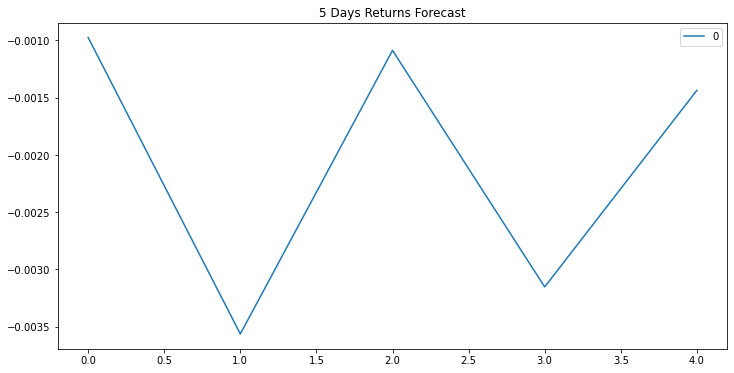

In [46]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Days Returns Forecast", figsize=(12,6))

**Question:** Based on the p-value, is the model a good fit?

**Answer:** Based on the p-value this model does not appear to be a good fit. The p-value for Lag 2 is 0.140. Any p-value higher than 0.05 would be considered not significant. The p-value of Lag 1 as you can see is 0.00, this indicates a model using order=(1, 1) would be a better fit.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [15]:
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
arima_model = ARIMA(cad_jpy_df['Price'], order=(5,1,1))

# Fit the model
arima_results = arima_model.fit()

In [16]:
# Output model summary results:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Wed, 19 Jan 2022   AIC                          17507.244
Time:                        16:42:31   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.855      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

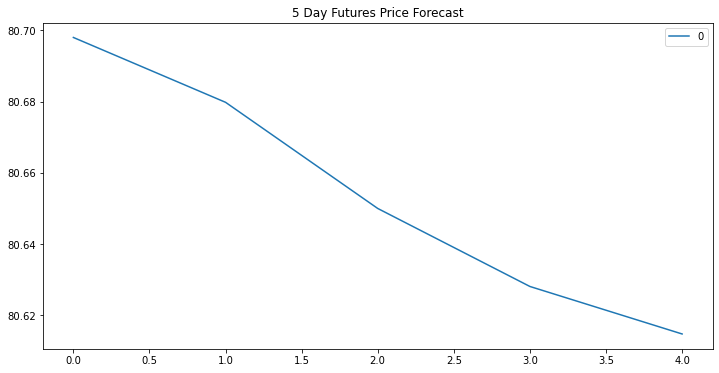

In [47]:
# Plot the 5 Day Price Forecast
pd.DataFrame(arima_results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast", figsize=(12,6))

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** 
1. Based on the p-value this model does not appear to be a good fit. The p-value for all Lags 2 is > 0.05. Any p-value > than 0.05 would be considered not significant. 

2. The model forcasts a downward trend of Japanese Yen Price in the near term.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [35]:
# Estimate a GARCH model:
garch_model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
garch_results = garch_model.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 83967.15660803435
Iteration:      2,   Func. Count:     18,   Neg. LLF: 46800.089672068425
Iteration:      3,   Func. Count:     28,   Neg. LLF: 620567642.8938148
Iteration:      4,   Func. Count:     35,   Neg. LLF: 4505781788.871186
Iteration:      5,   Func. Count:     43,   Neg. LLF: 8952.247178079739
Iteration:      6,   Func. Count:     50,   Neg. LLF: 10961.20965256629
Iteration:      7,   Func. Count:     57,   Neg. LLF: 8975.498103870486
Iteration:      8,   Func. Count:     65,   Neg. LLF: 8910.931931210092
Iteration:      9,   Func. Count:     71,   Neg. LLF: 8926.789304986882
Iteration:     10,   Func. Count:     78,   Neg. LLF: 8912.468506111007
Iteration:     11,   Func. Count:     85,   Neg. LLF: 8910.284913834232
Iteration:     12,   Func. Count:     91,   Neg. LLF: 8910.284859670548
Iteration:     13,   Func. Count:     97,   Neg. LLF: 8910.2848590529
Optimization terminated successfully    (Exit mode 0)
           

In [48]:
# Summarize the model results
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8910.28
Distribution:                  Normal   AIC:                           17830.6
Method:            Maximum Likelihood   BIC:                           17865.5
                                        No. Observations:                 7928
Date:                Wed, Jan 19 2022   Df Residuals:                     7927
Time:                        17:04:52   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.3175e-03  7.879e-03      1.183      0.237 [-6.125e-03,2.476e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.1837e-03  2.579e-03      3.560  3.702e-04  [4.128e-03,1.424e-02]
alpha[1]       0.0629  1.853e-02      3.397  6.821e-04  [2.662e-02,9.927e-02]
alpha[2]   1.1005e-11  2.024e-02  5.437e-10      1.000 [-3.967e-02,3.967e-02]
beta[1]        0.9236  1.249e-02     73.934      0.000      [  0.899,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [37]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [38]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = garch_results.forecast(start=last_day, horizon=forecast_horizon)

In [39]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.512045,12.520662,12.529156,12.537532,12.545789


In [28]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

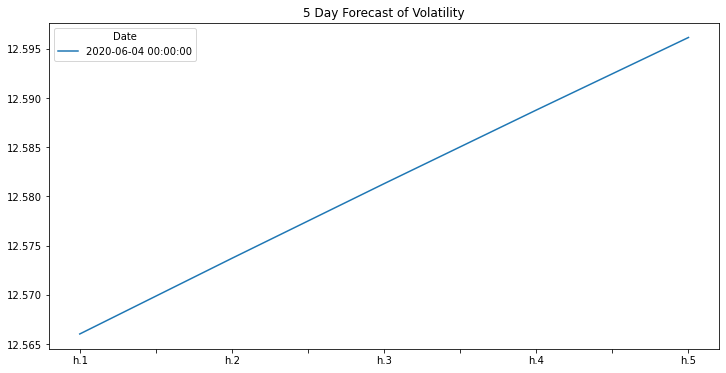

In [34]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility", figsize=(12,6))

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** The model forecasts **increased** volatility in the near term. 

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?
    * No, our modelling for returns was not a good fit, along with additional moddelling predicting an increase in volatility in the short term.

2. Is the risk of the yen expected to increase or decrease?
    * The volatility if the yen and therefore risk is expected to increase.

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * No I wouldnt be confident trading with these models. Both the ARMA and ARIMA models where not a good fit for this data as evident from the p-values. The GARCH model was a better fit for the data, with the results showing us there would be an increase in volatility. I would not be confident trading on volatility predictions alone. 